In [ ]:
!pip install python-dotenv python-binance 

In [ ]:
import os
import datetime

from dotenv import load_dotenv
from binance import Client
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import tensorflow.keras as keras

In [ ]:
google_drive_dir = '/content/drive/MyDrive/Colab Notebooks/crypto_trader/'
load_dotenv(google_drive_dir + '.env')

api_key = os.getenv('READONLY_API_KEY')
secret_key = os.getenv('READONLY_SECRET_KEY')

client = Client(api_key, secret_key)

# Trainer

In [ ]:
class Trainer:
	def __init__(self, client, model=None, window_size=5):
		self.client = client
		self.model = model
        # number of trailing candlesticks
		self.window_size = window_size 
		self.datasethandler = DatasetHandler(client, window_size)


	def build_new_dataset(self, symbol, interval, period):
		self.datasethandler.generate_dataset(symbol, interval, period)
		self.train_dataset, self.valid_dataset, self.test_dataset = self.datasethandler.get_datasets()
  

    def load_dataset(self, name)
		self.train_dataset, self.valid_dataset, self.test_dataset = self.datasethandler.get_datasets(name)


	def train(self):
		self.model.fit(
				self.train_dataset,
				epochs=3,
				validation_data=self.valid_dataset,
	            callbacks=[keras.callbacks.ReduceLROnPlateau(patience=5, verbose=True)],
			)
		self.visual_validation()


	def visual_validation(self, n=20):
		pass

# DatasetHandler

In [ ]:
class DatasetHandler:
	def __init__(self, client, window_size):
		self.client = client
		self.window_size = window_size
		self.data_shape = (5, 14)
		self.target_shape = (1, 1)


	def create_directories(self):
		timestamp = datetime.datetime.now().strftime("%Y-%m-%d_%H:%M:%S")
		self.dataset_directory = f'./data/{timestamp}/'
		os.makedirs(self.dataset_directory + 'train')
		os.makedirs(self.dataset_directory + 'valid')
		os.makedirs(self.dataset_directory + 'test')


	def generate_dataset(self, symbol='BTCUSDT', interval='1m', period='90m'):
		self.create_directories()
		
		self.symbol = symbol
		if self.symbol == 'BTCUSDT':
			self.base = 'BTC'
			self.quote = 'USDT'

		print('getting history')
		self.history = self.get_history(symbol, interval, period)
		print('preparing data')
		self.dataframe, self.target = self.prepare_data(self.history)

		subsets = self.train_test_valid_split(train=.7, valid=.2, test=.1)
		
		for ids, name in zip(subsets, ('train', 'test', 'valid')):
			print(f'writing tfrecords: {name} dataset')
			self.write_tfrecords(ids, name)


	def get_datasets(self, dataset_directory=None):
		dataset_directory = f'./data/{dataset_directory}/' if dataset_directory is not None else self.dataset_directory
		train_filenames = tf.io.gfile.glob(dataset_directory + 'train/*.tfrecord')
		valid_filenames = tf.io.gfile.glob(dataset_directory + 'valid/*.tfrecord')
		test_filenames = tf.io.gfile.glob(dataset_directory + 'test/*.tfrecord')

		self.train_dataset = self.load_dataset(train_filenames)
		self.valid_dataset = self.load_dataset(valid_filenames)
		self.test_dataset = self.load_dataset(test_filenames)

		return self.train_dataset, self.valid_dataset, self.test_dataset


	def get_history(self, symbol, interval, period):
		# klines = self.client.get_historical_klines(symbol=symbol, interval=interval, start_str= period + ' ago UTC')
		# labels = ['Open time', 'Open', 'High', 'Low', 'Close', 
		# 		  self.base + ' volume', 'Close time', self.quote + ' volume', 'Number of trades',
		# 		  f'{self.base} buy volume', f'{self.quote} sell volume', 'Ignore']
		# df = pd.DataFrame(data=klines, columns=labels, dtype=float)
		# df.to_csv('./data/history.csv', index=False)
		df = pd.read_csv(google_drive_dir + 'data/15m_3y.csv')

		return df


	def prepare_data(self, df):
		df = df.drop(columns=['Open time', 'Open', 'Close time', 'Ignore', self.quote + ' volume'])

		df['Buy / volume ratio'] = df[f'{self.base} buy volume'] / (df[self.base + ' volume'])
		df['Sell / volume ratio'] = 1 - df['Buy / volume ratio']
		
		MAs = (3, 7, 25, 99, 250)
		for avg in MAs:
			df[f'{avg} MA'] = df['Close'].rolling(avg).mean()

		for attr in ('High', 'Low', 'Close') + tuple(f'{avg} MA' for avg in MAs):
			df[attr].iloc[1:] = (df[attr].iloc[1:] / df[attr].iloc[:-1].values)

		df = df.dropna()
		target = df['Close']
		target = np.sqrt(target)
		target = target.iloc[1:]
		
		df = (df - df.min()) / (df.max() - df.min())

		self.data_shape = (self.window_size, len(df.iloc[0]))

		return df, target


	def train_test_valid_split(self, train, valid, test):
		ids = np.random.permutation(np.arange(self.window_size, len(self.dataframe) - 1))
		splits = [int(len(ids) * train), int(len(ids) * (train + valid))]
		subsets = np.split(ids, splits)
		return subsets


	def write_tfrecords(self, ids, name):
		def _bytes_feature(value):
		    if isinstance(value, type(tf.constant(0))):
		        value = value.numpy()
		    return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))

		def _float_feature(value):
		    return tf.train.Feature(float_list=tf.train.FloatList(value=[value]))

		def _int64_feature(value):
		    return tf.train.Feature(int64_list=tf.train.Int64List(value=[value]))

		def serialize_example(data, target):
			feature = {
				'data': _bytes_feature(data),
				'target': _bytes_feature(target),
			}
			example = tf.train.Example(features=tf.train.Features(feature=feature))
			return example.SerializeToString()

		def tf_serialize_example(args):
			tf_string = tf.py_function(serialize_example, *args, tf.string)
			return (tf.reshape(tf_string, ()))

		dataset = []
		for i in ids:
			data = self.dataframe.iloc[i-self.window_size:i].to_numpy()
			target = self.target.iloc[i].reshape((1, 1))

			data = tf.convert_to_tensor(data)
			target = tf.convert_to_tensor(target)

			example = serialize_example(tf.io.serialize_tensor(data), tf.io.serialize_tensor(target))
			dataset.append(example)

		print(f'{name} set has {len(dataset)} samples')
		dataset = tf.data.Dataset.from_tensor_slices(dataset)

		filename = self.dataset_directory + name + '/rec.tfrecord'
		writer = tf.data.experimental.TFRecordWriter(filename)

		writer.write(dataset)


	def load_dataset(self, filenames):
		def deserialize(example):
			return tf.io.parse_single_example(example, features_description)

		def parse_tensors(example):
			example = {name: tf.io.parse_tensor(example[name], tf.float64) for name in example}
			return example['data'], example['target']

		def reshape_tensors(data, target):
			data = tf.reshape(data, self.data_shape)
			target = tf.reshape(target, self.target_shape)
			return data, target

		features_description = {
			'data': tf.io.FixedLenFeature([], tf.string),
			'target': tf.io.FixedLenFeature([], tf.string),
		}

		dataset = tf.data.TFRecordDataset(filenames)
		dataset = dataset.map(deserialize)
		dataset = dataset.map(parse_tensors)
		dataset = dataset.map(reshape_tensors)
		dataset = dataset.batch(32)

		return dataset

# Model

In [ ]:
def get_model():
    model = get_candlestick_rnn_model()
    model.compile(
            optimizer=keras.optimizers.SGD(learning_rate=.1, momentum=.9, nesterov=True),
            loss='mse',
        )
    return model



def get_candlestick_rnn_model():
    model = keras.models.Sequential()

    # model.add(keras.layers.LSTM(50, recurrent_dropout=.5, return_sequences=True))
    model.add(keras.layers.LSTM(50, recurrent_dropout=.5, return_sequences=False))
    model.add(keras.layers.Dense(1))

    return model



# Testing

In [ ]:
model = get_model()
trainer = Trainer(client, model)

In [ ]:
trainer.build_new_dataset(
				symbol='BTCUSDT', 
				interval='15m', 
				period='3 years',
				# period='1000 minutes',
	)

Epoch 1/3
2290/2290 [==============================] - 23s 9ms/step - loss: 8.2942e-04 - val_loss: 6.9558e-06
Epoch 2/3
2290/2290 [==============================] - 21s 9ms/step - loss: 9.9528e-06 - val_loss: 6.0192e-06
Epoch 3/3
2290/2290 [==============================] - 20s 9ms/step - loss: 7.5647e-06 - val_loss: 5.4853e-06
min prediction: 0.9942332
max prediction: 1.0036957


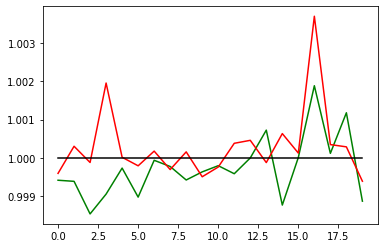

In [ ]:
trainer.train()